In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras # ML

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars

BASE_DIR = Path("EmbryoLabeling/Labelers/One")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/*.jpg"), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

2022-04-29 02:26:21.601588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 02:26:21.639881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 02:26:21.640070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Morula               82
Empty                75
Compacting 8 cell    38
2 Cell               36
Blastocyst           35
4 Cell               31
2pn                  19
Early blast           8
Cavitating morula     7
7 Cell                6
Syngamy               5
8 Cell                5
10 plus Cell          4
5 Cell                4
3 Cell                4
9 Cell                3
6 Cell                1
Name: class, dtype: int64

<AxesSubplot:>

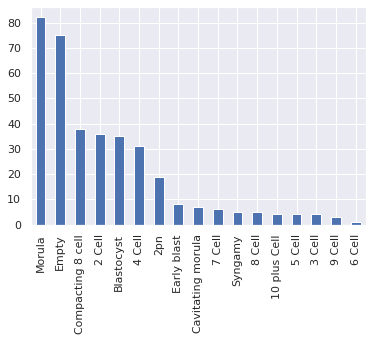

In [2]:
df["class"].value_counts().plot.bar()

In [3]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [4]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(10)
        validation_rows.append(validation_sample)
        #train_sample = df_for_class.drop(validation_sample.index).sample(30)
        train_sample = df_for_class.drop(validation_sample.index)
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/One/Morula/M776_S0087_W2_F0_4676.jpg,Morula
1,EmbryoLabeling/Labelers/One/Morula/M776_S0087_W2_F0_5920.jpg,Morula
2,EmbryoLabeling/Labelers/One/Morula/M776_S0087_W2_F0_5336.jpg,Morula
3,EmbryoLabeling/Labelers/One/Morula/M776_S0087_W2_F0_4366.jpg,Morula
4,EmbryoLabeling/Labelers/One/Morula/M776_S0087_W2_F0_5176.jpg,Morula
...,...,...
34,EmbryoLabeling/Labelers/One/Blastocyst/M776_S0087_W2_F0_6351.jpg,Blastocyst
0,EmbryoLabeling/Labelers/One/6 Cell/M776_S0087_W2_F0_3125.jpg,6 Cell
0,EmbryoLabeling/Labelers/One/9 Cell/M776_S0087_W2_F0_4146.jpg,9 Cell
1,EmbryoLabeling/Labelers/One/9 Cell/M776_S0087_W2_F0_4186.jpg,9 Cell


Morula               72
Empty                65
Compacting 8 cell    28
2 Cell               26
Blastocyst           25
4 Cell               21
Name: class, dtype: int64

Morula               10
4 Cell               10
2 Cell               10
Empty                10
Compacting 8 cell    10
Blastocyst           10
Name: class, dtype: int64

In [5]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=24, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=24, shuffle=False)

Found 237 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.


In [6]:
assert training.class_indices == validation.class_indices

In [7]:
list(training.class_indices.keys())

['2 Cell', '4 Cell', 'Blastocyst', 'Compacting 8 cell', 'Empty', 'Morula']

In [8]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '4 Cell',
 2: 'Blastocyst',
 3: 'Compacting 8 cell',
 4: 'Empty',
 5: 'Morula'}

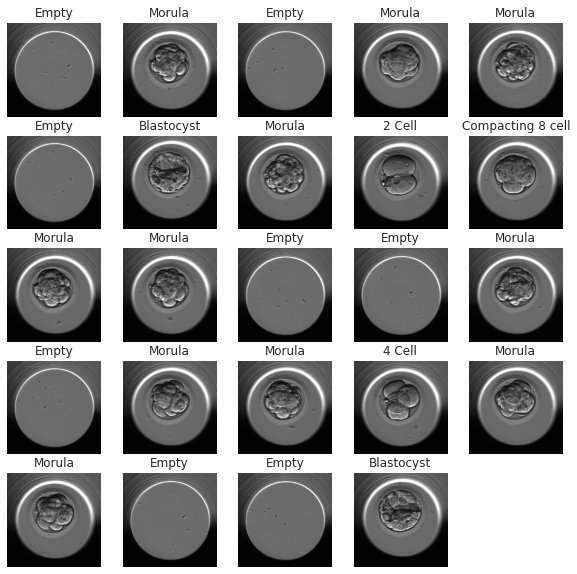

In [9]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

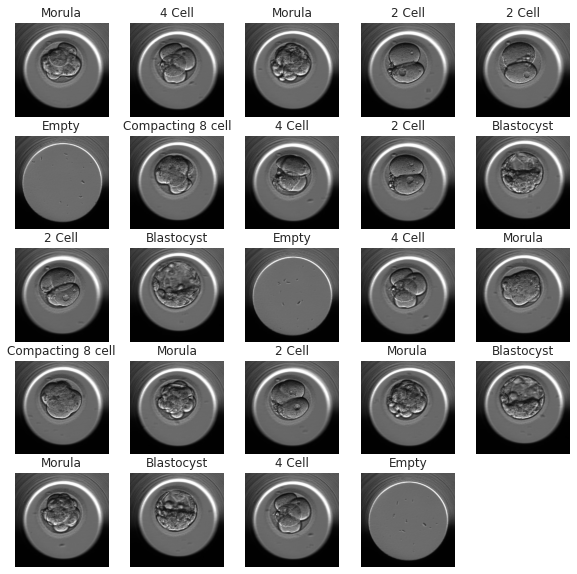

In [10]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [11]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-04-29 02:26:25.572610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 02:26:25.573999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 02:26:25.574220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 02:26:25.574348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
____________________________________________

In [12]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(training, epochs=60, validation_data=validation)

Epoch 1/60


2022-04-29 02:26:30.556533: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-04-29 02:26:31.263825: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


10/10 [==============================] - 6s 245ms/step - loss: 1.3887 - categorical_accuracy: 0.5359 - val_loss: 1.4861 - val_categorical_accuracy: 0.3333
Epoch 2/60
10/10 [==============================] - 1s 113ms/step - loss: 0.9512 - categorical_accuracy: 0.6371 - val_loss: 0.9859 - val_categorical_accuracy: 0.6500
Epoch 3/60
10/10 [==============================] - 1s 108ms/step - loss: 0.7016 - categorical_accuracy: 0.8565 - val_loss: 0.7584 - val_categorical_accuracy: 0.7333
Epoch 4/60
10/10 [==============================] - 1s 118ms/step - loss: 0.5299 - categorical_accuracy: 0.8776 - val_loss: 0.5954 - val_categorical_accuracy: 0.8833
Epoch 5/60
10/10 [==============================] - 1s 108ms/step - loss: 0.4424 - categorical_accuracy: 0.9325 - val_loss: 0.4834 - val_categorical_accuracy: 0.8833
Epoch 6/60
10/10 [==============================] - 1s 115ms/step - loss: 0.3780 - categorical_accuracy: 0.9072 - val_loss: 0.4457 - val_categorical_accuracy: 0.8833
Epoch 7/60
10/1

10/10 [==============================] - 1s 112ms/step - loss: 0.0494 - categorical_accuracy: 1.0000 - val_loss: 0.0940 - val_categorical_accuracy: 0.9833
Epoch 51/60
10/10 [==============================] - 1s 105ms/step - loss: 0.0461 - categorical_accuracy: 1.0000 - val_loss: 0.0776 - val_categorical_accuracy: 0.9833
Epoch 52/60
10/10 [==============================] - 1s 105ms/step - loss: 0.0452 - categorical_accuracy: 1.0000 - val_loss: 0.0861 - val_categorical_accuracy: 0.9833
Epoch 53/60
10/10 [==============================] - 1s 106ms/step - loss: 0.0445 - categorical_accuracy: 1.0000 - val_loss: 0.0842 - val_categorical_accuracy: 0.9833
Epoch 54/60
10/10 [==============================] - 1s 102ms/step - loss: 0.0426 - categorical_accuracy: 1.0000 - val_loss: 0.0837 - val_categorical_accuracy: 0.9833
Epoch 55/60
10/10 [==============================] - 1s 102ms/step - loss: 0.0414 - categorical_accuracy: 1.0000 - val_loss: 0.0798 - val_categorical_accuracy: 0.9833
Epoch 56/6

<AxesSubplot:>

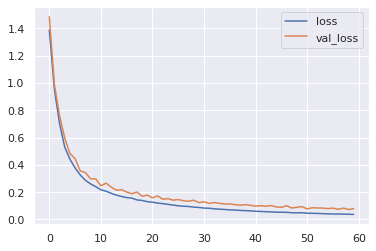

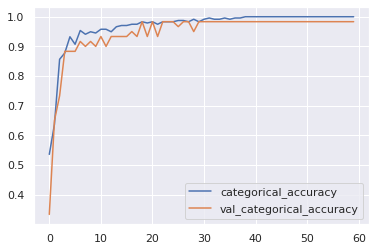

In [13]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [14]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [5, 1, 5, 0, 0, 4, 3, 1, 0, 2, 0, 2, 4, 1, 5, 3, 5, 0, 5, 2, 5, 2, 1, 4, 5, 5, 1, 4, 4, 4, 4, 3, 2, 4, 2, 3, 1, 1, 3, 1, 4, 1, 3, 0, 0, 0, 5, 0, 3, 3, 3, 2, 3, 2, 0, 2, 5, 2, 4, 1]
Predictions:  [5 1 5 0 0 4 3 1 0 2 0 2 4 1 5 3 5 0 5 2 5 2 1 4 5 5 1 4 4 4 4 3 2 4 2 3 1
 1 3 1 4 1 3 0 0 0 5 0 3 5 3 2 3 2 0 2 5 2 4 1]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        10
           5       0.91      1.00      0.95        10

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



Text(30.499999999999993, 0.5, 'True')

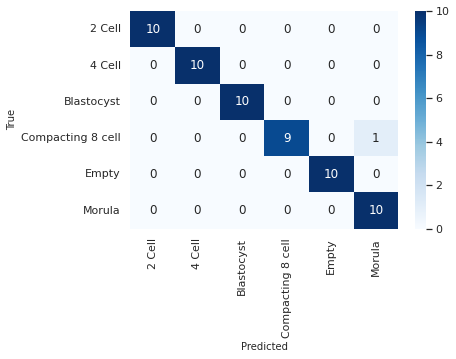

In [15]:
validation.reset()
y_pred = model.predict(validation).argmax(axis=1)
print(classification_report(validation.labels, y_pred))
labels = list(training.class_indices.keys())
s = sns.heatmap(confusion_matrix(validation.labels, y_pred), annot=True, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [16]:
model.save(f"models/{len(code2class)}_class.h5")